# DELIVERABLE 2 

## STEP 2: Random data generation

We start by generating points with random coordinates.<br>
The distance matrix is then calculated between each point.<br>
And we end up placing the preceding gener points in a graph that will be saved in a PNG file.

In [24]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.spatial import distance_matrix

number_cities = 500
x_max         = 100000    # maximum coordinates of a city on the x axis
y_max         = 100000    # maximum coordinates of a city on the y axis

coords        = np.random.randint([x_max, y_max], size=(number_cities, 2))  # Creation of a random matrix of city coordinates

print(coords)

[[57398  4936]
 [26577 24399]
 [86802 15016]
 [36235 69914]
 [99405 41872]
 [94690 27216]
 [80622 22649]
 [ 9248 57754]
 [43187 99134]
 [93154 63226]
 [19556 16130]
 [77369 84491]
 [75578 19700]
 [93092 70093]
 [  146 55165]
 [22805 34981]
 [57246 24340]
 [77782 33537]
 [24676 27565]
 [77469 47822]
 [35321 83881]
 [ 7335 52347]
 [33035 25958]
 [ 6431 98669]
 [94549 91291]
 [35138  5427]
 [58550 66147]
 [23126 82102]
 [ 7851  2602]
 [78972 74303]
 [71032 91119]
 [44941 16877]
 [70870 97887]
 [82225 73506]
 [70203 63498]
 [41547 34690]
 [29931  3137]
 [48364 38168]
 [ 3571 90554]
 [54886 71474]
 [46250 80875]
 [64235 70601]
 [23635 42193]
 [ 2535 71586]
 [89686  8228]
 [70148  3190]
 [ 2156 61650]
 [23429 39323]
 [95091 82093]
 [20882 51872]
 [81831 58701]
 [50130 70099]
 [24649 60781]
 [26710 34185]
 [11925 67602]
 [36621 38124]
 [64207 66870]
 [72066 98043]
 [ 6821 53214]
 [14207 14133]
 [54034 73105]
 [23969 96170]
 [62567 25080]
 [45866 80995]
 [28664 16757]
 [ 8092 69019]
 [51427 13

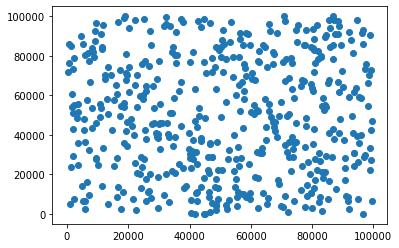

In [5]:
x, y = coords.T    # We define that the first value of coords is X and the second is Y
plt.scatter(x,y)   # Put the x and y axis in pyplot
plt.show()         # Display the coordinates of the cities on an orthonormal coordinate system

In [25]:

'''
Generate city names in alphabetical order
'''
cities = []

for i in range(number_cities):
    city = chr(ord('A') + i)
    cities.append(city)

'''
Creation of the matrix of distances between cities
'''

df       = pd.DataFrame(coords, columns=['xcord', 'ycord'],    index=cities)
matrix   = distance_matrix(df.values, df.values)
distance = pd.DataFrame(matrix, index=df.index, columns=df.index)

print(df)
print(distance)

    xcord  ycord
A   57398   4936
B   26577  24399
C   86802  15016
D   36235  69914
E   99405  41872
..    ...    ...
Ȱ   79923  19382
ȱ   37982  93579
Ȳ   28462  49643
ȳ   48620  77139
ȴ   75742  63273

[500 rows x 2 columns]
               A             B             C             D             E  \
A       0.000000  36451.919154  31083.783811  68337.493757  55936.179213   
B   36451.919154      0.000000  60951.548906  46528.401961  74894.748234   
C   31083.783811  60951.548906      0.000000  74637.871707  29666.148132   
D   68337.493757  46528.401961  74637.871707      0.000000  69114.417194   
E   55936.179213  74894.748234  29666.148132  69114.417194      0.000000   
..           ...           ...           ...           ...           ...   
Ȱ   26759.344928  53581.396072   8147.551595  66799.134485  29754.805057   
ȱ   90744.490218  70113.810515  92496.147860  23729.395989  80289.468662   
Ȳ   53254.182418  25314.279784  67842.352030  21710.204283  71367.343302   
ȳ   72734.63

In [63]:
G        = nx.from_numpy_matrix(np.matrix(distance.round(1)), create_using=nx.DiGraph)  # Convert our matrix to a matrix readable by networkx
layout   = nx.spring_layout(G)                                                          # Position the nodes in a plane
labels   = nx.get_edge_attributes(G, "weight")                                          # We recover the weight of the edges

for i in range(number_cities):                                    # Add the name of the cities
    G.add_node(i, desc=cities[i])

node_labels = nx.get_node_attributes(G, 'desc')                   # Get the names of cities
    
nx.draw(G, layout, edge_color='black', width=1, linewidths=1,\
        node_size=500, node_color='pink', alpha=0.9)              # Graph configuration

nx.draw_networkx_labels      (G, pos=layout, labels=node_labels)  # We add the labels of the nodes to the graph
nx.draw_networkx_edge_labels (G, pos=layout, edge_labels=labels)  # We add the labels of the edge to the graph
plt.savefig("Graph.png", format="PNG")                            # We save the graph in a png file
plt.show()                                                        # Display the graph

C:\Users\Thomas\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 127 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Thomas\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 127 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\Thomas\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Thomas\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\Thomas\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 129 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Thomas\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 129 missing from current fon

KeyboardInterrupt: 

## <strong> STEP 3: Modeling the problem </strong>

### - Definition of the formal problem

The ADEME wants to find new solutions to regulate and reduce the environmental impact of products deliveries.

For this, our structure CesiCDP must put in place new technologies to optimize the management of resources and the logistics of road traffic. So, we must manage a delivery round thanks to operational research and the VRP (Vehicle Routing Problem) problem.
 
The algorithmic problem therefore consists in calculating a route on a road network making it possible to link a subset of cities together, then to return to its starting point, to minimize the total duration of the tour. This optimization will have to take into account the traffic planned on each axis for the different time slots.

### Mathematical formulation :  

The VRP formulation that we present here corresponds to the mathematical formulation used in linear integer programming. It translates the natural modeling of the problem by the definition of a binary variable Xijk equal to 1 if the vehicle k crosses the arc (Vi, Vj), denoted more simply (i, j).
 
We assume that the graph G = (V, E) is complete, so that all the vertices are connected to each other. This means that a city can be visited from any other city.
  
  
The other constants of the problem are as follows:  
<strong> n </strong> number of clients (or vertices) 
<strong> m </strong> number of vehicles  
<strong> Q </strong> vehicle capacity  
<strong> qi </strong> request from client i  
<strong> Cij </strong> the cost of the edge between vertices i and j (distance or travel time)  

The decision variables of the problem are the <strong> xijk </strong> mentioned above:  
  
<strong> Xijk = 1 if (i, j) </strong> is traveled by vehicle <strong> k </strong>,  
<strong> Xijk = 0 </strong> otherwise.  
 
Thus, as an optimization problem, the VRP is written:

### 1) $\sum \limits _{i=1} ^{n} \sum \limits _{i=1} ^{m} Cij \sum \limits _{i=1} ^{m} Xijk$

<br>

A complete graph with n vertices has n (n − 1) 2 edges:  

### 2)  $\sum \limits _{i=1} ^{n} \sum \limits _{k=1} ^{m} Xijk = 1 ∀ 1 ≤ j ≤ n$

### 3)  $\sum \limits _{j=1} ^{n} \sum \limits _{k=1} ^{m} Xijk = 1 ∀ 1 ≤ i ≤ n$

### 4)  $\sum \limits _{i=1} ^{n} \sum \limits _{l=1} ^{n} Xijk = \sum \limits _{l=1} ^{n}\sum \limits _{j=1} ^{n} Xijk$

### 5)  $\sum \limits _{j=1} ^{n} X0jk = 1 ∀ 1 ≤ k ≤ m$

### 6)  $\sum \limits _{i=1} ^{n} Xi0k = 1 ∀ 1 ≤ k ≤ m$

### 7)  $\sum \limits _{i=1} ^{n} \sum \limits _{j=1} ^{n} Xijk ≤ Q ∀ 1 ≤ k ≤ m$


#### Xijk ∈ 0, 1 ∀ 0 ≤ i, j ≤ n; 1 ≤ k ≤ m

Under this formulation, 
(1) means that the objective of the optimization problem is to minimize the sum of the costs of all the routes.  
The constraints (2) and (3) require that each customer be served once and only once and the constraints (4) ensure flow conservation.  
Constraints (5) ensure that each tour begins and ends at the depot.  
Finally, the constraints (6) are the capacity constraints and the constraints (7) are binary constraints on the Xijk decision variables.
<br>
<br>
**Resources: Synthèse du problème de routage de véhicules - Collection des rapports de recherche de Télécom Bretagne - RR-2011-03-LUSSI**<br>
The document is located in the "Resources" folder.


### - The complexity study of this problem

### Proof that VRP has "at least" the complexity of TSP  

The problem of vehicle tours is NP-Hard.  
  
Since this is not a decision problem (its return type is not bool), it cannot be in NP, although it has decision versions that are.  
  
This problem is a natural generalization of a problem that is already NP Difficult, in particular the traveling salesman problem or TSP. To prove that a problem is NP-Hard, reduces  it to another NP-Hard problem. The TSP is trivially reduced to a VRP instance with an available vehicle.  
  
  
  
### Proof that TSP is NP-Complete  

You have to show two things, that Traveling Salesman (TSP) is in NP and that TSP is NP-Hard. These requirements derive from the definition of NP-Completeness.  

**Part 1: TSP is in NP**

Proof: Let S be an index which is a sequence of vertices V = v1, ..., vn.  
We then check two things, that each edge crossed by adjacent vertices is an edge in G (usually not necessary, since G is traditionally a complete graph), such that the sum of these edge weights is less than or equal to k.  
Second, we check that every vertex of G is in V, which ensures that every node has been crossed. We accept S if and only if S satisfies these two questions, otherwise we reject. These two checks are clearly polynomial, so our algorithm forms a checker with the index S, and TSP is therefore in NP.
  
  
**Part 2: TSP is NP-Hard**


Proof: To show that TSP is NP-Hard, we have to show that any problem y in NP reduces to TSP in polynomial time.  
   
To do this, consider the decisional version of the Hamiltonian cycle (HC). It is well known that HC is NP-Complete, therefore HC is NP-Hard and each "Y" problem in NP reduces to HC in polynomial time. If we reduce HC to TSP in polynomial time, then we will have shown that any "Y" in NP reduced to TSP is a polynomial time, since the sum of two polynomials is also a polynomial.  
  
  
**Recall that the decision version of HC is:**  
Given a graph G = (V, E), is there a simple cycle in G that run through each vertex exactly once?  
Now observe that a simple cycle over n vertices has n edges.  
  
  
  
**Now to reduce HC to TSP use the following algorithm:**  
   
Take G = (V, E), set all edge weights equal to 1, and let k = | V | = n,  k is equal to the number of nodes in G.  
Any edge that is not at the origin in G then receives a weight of 2 (traditionally TSP is on a complete graph, so we have to add these extra edges). Then pass this modified graph in TSP, asking if there is a turn on G with a cost of at most k.  
If the answer to TSP is YES, then HC is YES. Likewise, if TSP is NO, then HC is NO.  
   
Proof: We have to show that the reduction takes a polynomial time and that the solutions of HC correspond 1-1 with the solutions of TSP using the reduction. Obviously, the reduction takes a polynomial time, so we end up with the latter.  
   
First direction: HC has a YES response => TSP has a YES response.   
Proof: If HC has a YES answer, then there exists a simple cycle C which visits each node exactly once, so C has n edges. Since each edge has a weight of 1 in the corresponding TSP instance for the edges that are in the HC graph, there is a round of weight n. Since k = n, and given that there is a round of weight n, it follows that TSP has a YES answer.  
   
Second direction: HC has a NO response => TSP has a NO response. Proof: If HC has an answer NO, then there is no simple cycle C in G that visits each vertex exactly once.  
Now suppose that TSP has a YES response. Then there is a tower that visits each vertex once with a weight of at most k. Since the tour requires that each node be crossed, there are n edges, and since k = n, each edge crossed must have a weight of 1, which implies that these edges are in the graph HC. Then do this round and cross the same edges in the HC instance. This forms a Hamiltonian cycle, a contradiction.  
   
This concludes part 2. Since we have shown that TSP is in both NP and NP-Hard, we have that TSP is NP-Complete, as required.  
  
  
### Conclusion

**Given that VRP is "at least" of the same complexity as TSP and that VRP is not NP. This means that VRP is necessarily NP-hard.**

# WIP: LA SUITE C'EST EN COURS DE REALISATION

# STEP 4 : Algorithmic Modeling

## 1 - Description of the algorithm used to solve VRP

### Why use the ant colony algorithm ?

According to studies carried out to know the best algorithm.  
   
For a little number of nodes:   
     
Taboo search and simulated annealing have better performance than other algorithms. Whether it is on the quality of the solution, the speed of the algorithm but also on the stability of the results, taboo search and simulated annealing have the best performances. It has been noted that the difference in the quality of the solution is particularly visible for larger test cases.  
   
For a case of a large number of nodes: The taboo search and simulated annealing methods give a solution with very similar and powerful differences. But a better result in almost all cases gives the ant colony optimization algorithm.  
 
**Conclusion :**  
The most suitable algorithm is therefore the ant algorithm, because we have a large number of nodes.

**Resources of the two scientific studies :**  
https://dk.upce.cz/bitstream/handle/10195/66616/Comparison%20of%20metaheuristic%20methods%20by%20solving%20travelling%20salesman%20problem.pdf?sequence=1&isAllowed=y <br>
https://www.researchgate.net/publication/312889331_Choice_of_best_possible_metaheuristic_algorithm_for_the_travelling_salesman_problem_with_limited_computational_time_Quality_uncertainty_and_speed

### Explanation of the ant colony algorithm

The original idea comes from the observation of the ant’s exploitation of food resources. Indeed,  although individually having limited cognitive abilities, are collectively able to find the shortest path between a food source and their nest.<br>
 <br>
Biologists have observed, in a series of experiments carried out starting in 1989, that an ant colony having the choice between two paths of unequal length leading to a food source tended to use the shorter path.<br>
A model explaining this behavior is as follows:<br>
 <br>
1.	an ant (called a "scout") roams more or less randomly in the environment around the colony;<br>
2.	if it discovers a source of food, it returns more or less directly to the nest, leaving a trail of pheromones in its path;<br>
3.	these pheromones being attractive, the ants passing nearby will tend to follow, more or less directly, this trail;<br>
4.	returning to the nest, these same ants will reinforce the trail;<br>
5.	if two tracks are possible to reach the same food source, the shorter one will be, at the same time, traveled by more ants than the long one;<br>
6.	the short track will therefore be more and more reinforced, and therefore more and more attractive;<br>
7.	the long track will eventually disappear, the pheromones being volatile;<br>
8.	eventually, all the ants determined and "chose" the shortest trail.<br>
 <br>
 <br>
 <br>
The ant colony algorithm aims to solve the traveling salesman problem, where the goal is to find the shortest path to connect a set of cities.<br>
The general algorithm is relatively simple, and relies on a set of ants, each traveling a path among those possible.<br>
At each step, the ant chooses to move from one city to another according to few rules:<br>
 <br>
•	she can only visit each city once;<br>
•	the further a city is, the less likely it is to be chosen (this is "visibility");<br>
•	the greater the intensity of the pheromone track placed on the ridge between two towns, the more likely the route will be chosen;<br>
•	once its journey is complete, the ant deposits more pheromones on all the edges traveled if the journey is short;<br>
•	the pheromone tracks evaporate with each iteration.<br>

**Resources :** <br>
https://fr.wikipedia.org/wiki/Algorithme_de_colonies_de_fourmis <br>
https://www.i3s.unice.fr/~crescenz/publications/travaux_etude/colonies_fourmis-200605-rapport.pdf <br>
http://villemin.gerard.free.fr/aMaths/Topologi/aaaGraph/Fourmis.htm <br>

## 2 - Python code implementing the model

Now we recover all the information we need for setting up the algorithm.<br>
That is to say :<br>
- The distances matrix<br>
- The total number of car over the 5 days<br>
- The total number of car over the 5 days in the morning and the evenings<br>
- The total number of car per day and by edge<br>
- The total number of car per day and by hours, but also by edge<br>

In [26]:

from pymongo  import MongoClient
import pprint

client                     =  MongoClient('localhost', 27017)
db                         =  client['DataProject']
collection_trafic_stamped  =  db['vehicules_stamped']

'''
Distance Matrix
'''
print(distance)

'''
Total number of cars
'''
total_car  = collection_trafic_stamped.aggregate([{"$group":{"_id":'',"nb_vehicules":{"$sum":'$nb_vehicules'}}},{"$project":{"_id":0,"Total_Vehicules":'$nb_vehicules'}}])
total_car  = list(total_car)[0]

print(total_car)
print("------------------------------------------- \n")
'''
Total number of cars morning and evening
'''
morning_car = 0
evening_car = 0

for x in collection_trafic_stamped.find({}, {"_id":0, "date":1, "nb_vehicules":1}):
    if x["date"].hour < 12:
        morning_car += x["nb_vehicules"]
    else:
        evening_car += x["nb_vehicules"]

print("Morning car number :", morning_car)
print("Evening car number  :", evening_car)
print("------------------------------------------- \n")

               A             B             C             D             E  \
A       0.000000  36451.919154  31083.783811  68337.493757  55936.179213   
B   36451.919154      0.000000  60951.548906  46528.401961  74894.748234   
C   31083.783811  60951.548906      0.000000  74637.871707  29666.148132   
D   68337.493757  46528.401961  74637.871707      0.000000  69114.417194   
E   55936.179213  74894.748234  29666.148132  69114.417194      0.000000   
..           ...           ...           ...           ...           ...   
Ȱ   26759.344928  53581.396072   8147.551595  66799.134485  29754.805057   
ȱ   90744.490218  70113.810515  92496.147860  23729.395989  80289.468662   
Ȳ   53254.182418  25314.279784  67842.352030  21710.204283  71367.343302   
ȳ   72734.630631  57161.188310  72918.668755  14338.369852  61829.422721   
ȴ   61153.151227  62676.830655  49508.197796  40061.277189  31905.177793   

               F             G             H             I             J  ...  \
A   43

In [34]:
'''
Total number of cars per day
'''
days             =  [1, 2, 3, 4, 5]
dict_total_day_  =  {}

for day in days:
    total_vehicles_day = list(collection_trafic_stamped.aggregate([
        {"$project":{"arete":1, "date":{"$dateToParts": { "date": "$date" }}, "nb_vehicules":1}},
        {"$match":{"date.day":day}}, 
        {"$group":{"_id":"$date.day", 
            "nb_vehicules":{"$sum":"$nb_vehicules"}}}, 
        {"$sort":{"_id": 1}} 
    ]))
    dict_total_day_["total_vehicles_day_%s" % (day)] = total_vehicles_day

'''
Total number of cars per day and per edge
'''
dict_day_  =  {}

for day in days:
    number_vehicles_edge_day = list(collection_trafic_stamped.aggregate([
        {"$project":{"arete":1, "date":{"$dateToParts": { "date": "$date" }}, "nb_vehicules":1}},
        {"$match":{"date.day":day}}, 
        {"$group":{"_id":"$arete", 
            "nb_vehicules":{"$sum":"$nb_vehicules"}}}, 
        {"$sort":{"_id": 1}} 
    ]))
    dict_day_["number_vehicles_day_%s" % (day)] = number_vehicles_edge_day


# print(dict_day_["number_vehicles_day_1"])

In [80]:
pprint.pprint(dict_day_["number_vehicles_day_5"])

[{'_id': 0, 'nb_vehicules': 16841},
 {'_id': 1, 'nb_vehicules': 20009},
 {'_id': 2, 'nb_vehicules': 20384},
 {'_id': 3, 'nb_vehicules': 19057},
 {'_id': 4, 'nb_vehicules': 17320},
 {'_id': 5, 'nb_vehicules': 19243},
 {'_id': 6, 'nb_vehicules': 18148},
 {'_id': 7, 'nb_vehicules': 19917},
 {'_id': 8, 'nb_vehicules': 19137},
 {'_id': 9, 'nb_vehicules': 19035},
 {'_id': 10, 'nb_vehicules': 19299},
 {'_id': 11, 'nb_vehicules': 18398},
 {'_id': 12, 'nb_vehicules': 18372},
 {'_id': 13, 'nb_vehicules': 20019},
 {'_id': 14, 'nb_vehicules': 20369},
 {'_id': 15, 'nb_vehicules': 20779},
 {'_id': 16, 'nb_vehicules': 17958},
 {'_id': 17, 'nb_vehicules': 16579},
 {'_id': 18, 'nb_vehicules': 17247},
 {'_id': 19, 'nb_vehicules': 17890},
 {'_id': 20, 'nb_vehicules': 20821},
 {'_id': 21, 'nb_vehicules': 19203},
 {'_id': 22, 'nb_vehicules': 18369},
 {'_id': 23, 'nb_vehicules': 18375},
 {'_id': 24, 'nb_vehicules': 18758},
 {'_id': 25, 'nb_vehicules': 18923},
 {'_id': 26, 'nb_vehicules': 17551},
 {'_id': 27

In [28]:
'''
Total number of cars per hour and per edge
'''
days        =  [1, 2, 3, 4, 5]
hours       =  [7, 8, 17, 18]
dict_hour_  =  {}

for day in days:
    for hour in hours:
        number_vehicles_edge_hour = list(db.vehicules_stamped.aggregate([
            {"$project":{"arete":1, "date":{"$dateToParts": { "date": "$date" }}, "nb_vehicules":1}},
            {"$match": 
                {"$and": [
                    {"date.hour":{"$lte":(hour+1), "$gte":hour}},
                    {"date.day": day}
                ]}
            }, 
            {"$group":{"_id":"$arete", 
                "nb_vehicules":{"$sum":"$nb_vehicules"}}}, 
            {"$sort":{"_id": 1}} 
            ]))
        
        dict_hour_["number_vehicles_%s_%s" % (day, hour)] = number_vehicles_edge_hour
        print(dict_hour_["number_vehicles_1_7"])



b_vehicules': 6783}, {'_id': 442, 'nb_vehicules': 6775}, {'_id': 443, 'nb_vehicules': 7600}, {'_id': 444, 'nb_vehicules': 8364}, {'_id': 445, 'nb_vehicules': 8704}, {'_id': 446, 'nb_vehicules': 7686}, {'_id': 447, 'nb_vehicules': 6808}, {'_id': 448, 'nb_vehicules': 8417}, {'_id': 449, 'nb_vehicules': 7251}, {'_id': 450, 'nb_vehicules': 8076}, {'_id': 451, 'nb_vehicules': 9172}, {'_id': 452, 'nb_vehicules': 7414}, {'_id': 453, 'nb_vehicules': 6578}, {'_id': 454, 'nb_vehicules': 8757}, {'_id': 455, 'nb_vehicules': 7583}, {'_id': 456, 'nb_vehicules': 6930}, {'_id': 457, 'nb_vehicules': 6691}, {'_id': 458, 'nb_vehicules': 8514}, {'_id': 459, 'nb_vehicules': 6980}, {'_id': 460, 'nb_vehicules': 8253}, {'_id': 461, 'nb_vehicules': 7743}, {'_id': 462, 'nb_vehicules': 6848}, {'_id': 463, 'nb_vehicules': 8787}, {'_id': 464, 'nb_vehicules': 6923}, {'_id': 465, 'nb_vehicules': 7663}, {'_id': 466, 'nb_vehicules': 8855}, {'_id': 467, 'nb_vehicules': 9307}, {'_id': 468, 'nb_vehicules': 8093}, {'_id':

In [25]:
pprint.pprint(dict_hour_["number_vehicles_2_8"])

[{'_id': 0, 'nb_vehicules': 4523},
 {'_id': 1, 'nb_vehicules': 4425},
 {'_id': 2, 'nb_vehicules': 4928},
 {'_id': 3, 'nb_vehicules': 4586},
 {'_id': 4, 'nb_vehicules': 4913},
 {'_id': 5, 'nb_vehicules': 5141},
 {'_id': 6, 'nb_vehicules': 5545},
 {'_id': 7, 'nb_vehicules': 5497},
 {'_id': 8, 'nb_vehicules': 6167},
 {'_id': 9, 'nb_vehicules': 5778},
 {'_id': 10, 'nb_vehicules': 4796},
 {'_id': 11, 'nb_vehicules': 4645},
 {'_id': 12, 'nb_vehicules': 4224},
 {'_id': 13, 'nb_vehicules': 4995},
 {'_id': 14, 'nb_vehicules': 5379},
 {'_id': 15, 'nb_vehicules': 5770},
 {'_id': 16, 'nb_vehicules': 5329},
 {'_id': 17, 'nb_vehicules': 4306},
 {'_id': 18, 'nb_vehicules': 4519},
 {'_id': 19, 'nb_vehicules': 4699},
 {'_id': 20, 'nb_vehicules': 5200},
 {'_id': 21, 'nb_vehicules': 5163},
 {'_id': 22, 'nb_vehicules': 4312},
 {'_id': 23, 'nb_vehicules': 4627},
 {'_id': 24, 'nb_vehicules': 5522},
 {'_id': 25, 'nb_vehicules': 5688},
 {'_id': 26, 'nb_vehicules': 4409},
 {'_id': 27, 'nb_vehicules': 5319},
 {

## 3 - linear model

We seek to obtain the lower terminal of the optimal solution.<br>
But also the algorithmic bounds.<br>
(We do not take into account the traffic of cars in the calculated terminals).<br>

In [ ]:
'''
Lower Bound of the optimal solution
'''



For the algorithmic bounds, the following functions are used:<br>
<br>
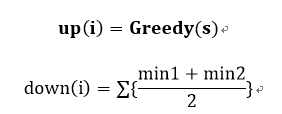
<br>
<br>
For the **upper bound** we use a greedy algorithm.<br>
<br>
The reason why the **lower bound** takes the two minimum values ​​of each row divided by 2 is: <br>
for the city j that passes through each step, from the nearest previous city i to the next nearest city k Go, i.e. j→k. The down obtained in this way must be less than or equal to the optimal solution. Up and down are constantly updated, the value of down will be updated every time a node is reached, and the value of up will be updated every time a solution is found (if it is better than the current up), if the current solution is smaller than the minimum value of all nodes If it is small, the search will be stopped when the optimal solution is found.

In [11]:
'''
Algorithmic - Lower Bound
'''
low  = 0 #lower bound
n    = matrix.shape[0]

for i in range(n):
        
        temp  =  matrix[i].copy()
        temp.sort()

        #print("%s"%(temp[0]))

        low   =  low+temp[0]+temp[1]

low = low / 2

print(low)

596901.2932908995


In [22]:
'''
Algorithmic - Upper Bound (using greedy algorithm)
'''
INF = 100000000

up=0

dfs_visited=[False]*n
dfs_visited[0]=True

def dfs(u,k,l):
    if k==n-1 :
        return (l+matrix[u][0])
    minlen=INF
    p=0
    for i in range(n):
        if dfs_visited[i]==False and minlen>matrix[u][i]:
            minlen=matrix[u][i]
            p=i
    dfs_visited[p]=True
    return dfs(p,k+1,l+minlen)
 
def get_up():
    global up
    up=dfs(0,0,0)

get_up()

print(up)

2087918.7341868507


# STEP 5: Implementation and statistical study of experimental behavior

In [139]:
'''
On crée une matrice avec le nombre de vehicule par jour et par arete
'''
list_vehicule = []
i = 1

matrix_car_day = [[x['nb_vehicules'] for x in dict_day_[day]] for day in dict_day_]

matrix_car_day = np.transpose(matrix_car_day)
#print(matrix_car_day[300])
print(matrix_car_day)

[[17345 17183 16677 17022 16841]
 [19619 19746 19476 19416 20009]
 [20002 20339 20209 20820 20384]
 ...
 [21596 21560 21330 21916 21783]
 [18296 18258 18438 18463 18682]
 [21359 21589 21970 21800 22064]]


# POUR PLUS TARD

FAIRE X = Nombre de noeud
ET Y le temps total

In [161]:
df2   = pd.DataFrame(columns=['day 1', 'day 2', 'day 3', 'day 4', 'day 5',], index=cities)
i     = 0

for car in matrix_car_day:
    df2.loc[cities[i]] = car
    i += 1

print(df2)

    day 1  day 2  day 3  day 4  day 5
A   17345  17183  16677  17022  16841
B   19619  19746  19476  19416  20009
C   20002  20339  20209  20820  20384
D   19596  19210  19193  19261  19057
E   17777  17569  17979  17749  17320
..    ...    ...    ...    ...    ...
Ȱ   19962  20398  20485  20293  19803
ȱ   17750  16905  17179  17176  17440
Ȳ   21596  21560  21330  21916  21783
ȳ   18296  18258  18438  18463  18682
ȴ   21359  21589  21970  21800  22064

[500 rows x 5 columns]


C:\Users\Thomas\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:584: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000021E2A894760> has a label of '_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
C:\Users\Thomas\anaconda3\lib\site-packages\matplotlib\textpath.py:74: RuntimeWarning: Glyph 127 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
C:\Users\Thomas\anaconda3\lib\site-packages\matplotlib\textpath.py:74: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
C:\Users\Thomas\anaconda3\lib\site-packages\matplotlib\textpath.py:74: RuntimeWarning: Glyph 129 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
C:\Users\Thomas\anaconda3\lib\site-packages\matplotlib\textpath.py:74: RuntimeWarning: Glyph 130 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
C:\Users\Thomas\anaconda3\li

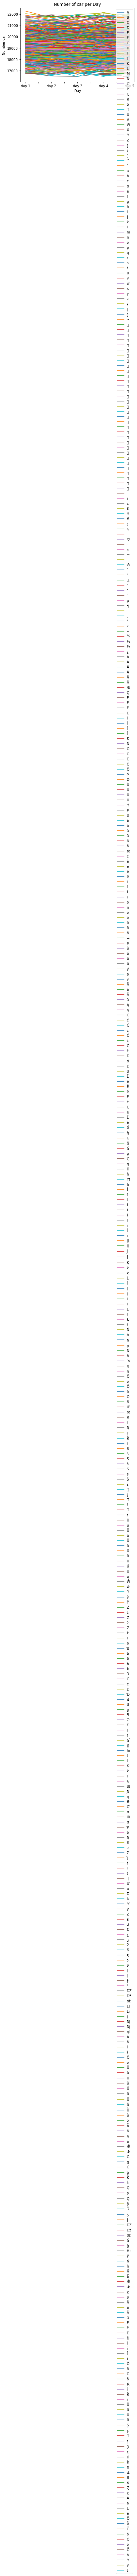

In [162]:
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline
'''
x = np.arange(1, 6)

for day in range(len(matrix_car_day)):
    plt.plot(x, matrix_car_day)

df2   = pd.DataFrame(columns=['day', 'number car'])
'''

df2.T.plot()  
plt.title('Number of car per Day')  
plt.xlabel("Day")
plt.ylabel("Number car") 
plt.show()  

C:\Users\Thomas\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Thomas\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Thomas\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

<AxesSubplot:xlabel='day 5', ylabel='Density'>

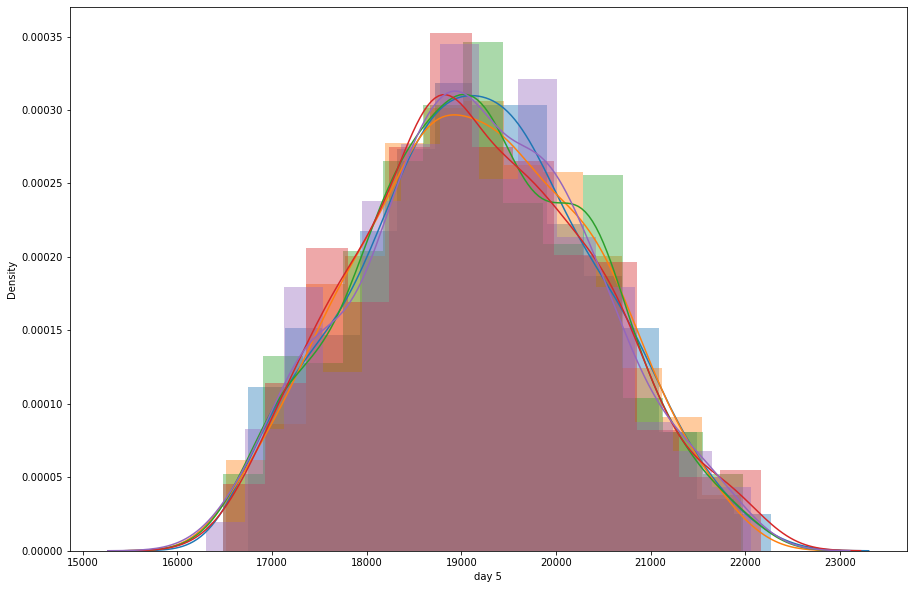

In [163]:
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(df2['day 1'])
seabornInstance.distplot(df2['day 2'])
seabornInstance.distplot(df2['day 3'])
seabornInstance.distplot(df2['day 4'])
seabornInstance.distplot(df2['day 5'])

In [11]:
X = df2['xcord'].values.reshape(-1,1)
Y = df2['ycord'].values.reshape(-1,1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

regressor = LinearRegression()  
regressor.fit(X_train, Y_train) #training the algorithm

#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

# variance score: 1 means perfect prediction
print('Variance score: {}'.format(model.score(X_test, Y_test)))
print("-------------------------\n\n")

Y_pred = regressor.predict(X_test)

df1 = pd.DataFrame({'Actual': Y_test.flatten(), 'Predicted': Y_pred.flatten()})
df1

[542138.96963922]
[[-0.11309214]]


,Actual,Predicted
0,696413,488358.569064
1,571168,514355.511103
2,26949,502645.498807
3,402104,496769.909890
4,55900,449520.919538
...,...,...
95,5688,513887.875114
96,958466,482035.135282
97,98134,481325.255935
98,690321,534933.304092


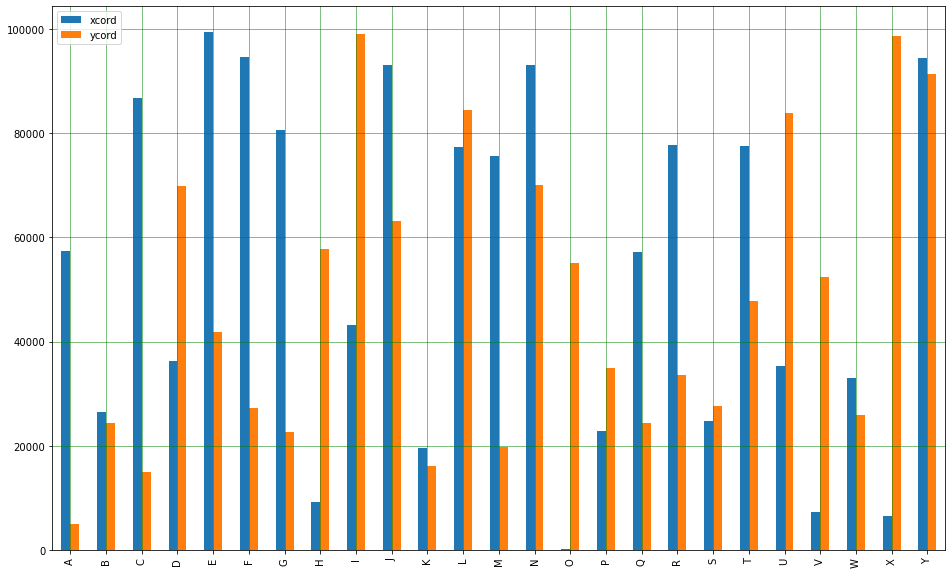

In [156]:
df2 = df2.head(25)
df2.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

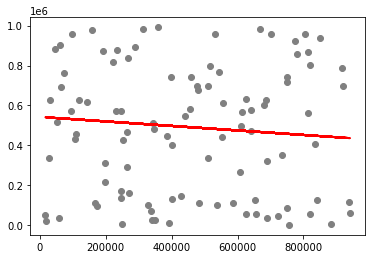

In [15]:
plt.scatter(X_test, Y_test,  color='gray')
plt.plot(X_test, Y_pred, color='red', linewidth=2)
plt.show()

# C EST UN AUTRE TEST DE REGRESSION LINEAIRE MAIS NUL

Regression Coefficients: [[-0.02701411]]
-------------------------

coefficient of determination: -0.0032967439478772675
-------------------------

Variance score: -0.01649141857363179
-------------------------




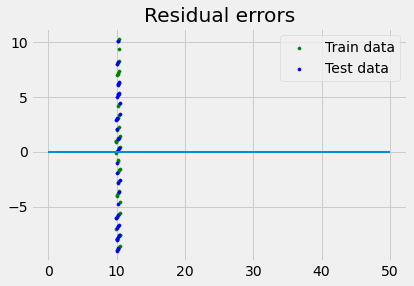

In [59]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

splited_coords = np.hsplit(coords,2)
X = splited_coords[0]
Y = splited_coords[1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=1)

# Create linear regression object AND Train the model using the training sets
model = LinearRegression().fit(X_train, Y_train)

# The regression coefficients
print('Regression Coefficients:', model.coef_)
print("-------------------------\n")

# coefficient of determination
r_sq = model.score(X, Y)
print('coefficient of determination:', r_sq)
print("-------------------------\n")

# variance score: 1 means perfect prediction
print('Variance score: {}'.format(model.score(X_test, Y_test)))
print("-------------------------\n\n")

## setting plot style
plt.style.use('fivethirtyeight')
 
## plotting residual errors in training data
plt.scatter(model.predict(X_train), model.predict(X_train) - Y_train,
            color = "green", s = 10, label = 'Train data')
 
## plotting residual errors in test data
plt.scatter(model.predict(X_test), model.predict(X_test) - Y_test,
            color = "blue", s = 10, label = 'Test data')
 
## plotting line for zero residual error
plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2)
 
## plotting legend
plt.legend(loc = 'upper right')
 
## plot title
plt.title("Residual errors")
 
## method call for showing the plot
plt.show()

# CODE Python ALGORITHME DE FOURMI

In [101]:
import  random                     as rn
from    numpy.random import choice as np_choice

def AntColony(distances, n_ants, n_best, n_iterations, decay, alpha=1, beta=1):
    """
    Args:
        distances (2D numpy.array): Square matrix of distances. Diagonal is assumed to be np.inf.
        n_ants (int): Number of ants running per iteration
        n_best (int): Number of best ants who deposit pheromone
        n_iteration (int): Number of iterations
        decay (float): Rate it which pheromone decays. The pheromone value is multiplied by decay, so 0.95 will lead to decay, 0.5 to much faster decay.
        alpha (int or float): exponenet on pheromone, higher alpha gives pheromone more weight. Default=1
        beta (int or float): exponent on distance, higher beta give distance more weight. Default=1
    Example:
        ant_colony = AntColony(german_distances, 100, 20, 2000, 0.95, alpha=1, beta=2)          
    """
    
    pheromone              = np.ones(distances.shape) / len(distances)
    all_inds               = range(len(distances))
    shortest_path          = None
    all_time_shortest_path = ("placeholder", np.inf)
    
    
    for i in range(n_iterations):
        all_paths = gen_all_paths(n_ants, pheromone, alpha, beta, all_inds)
        spread_pheronome(all_paths, n_best, pheromone, shortest_path=shortest_path)
        shortest_path = min(all_paths, key=lambda x: x[1])
        #print (shortest_path)
        if shortest_path[1] < all_time_shortest_path[1]:
            all_time_shortest_path = shortest_path            
        pheromone = pheromone * decay            
    return all_time_shortest_path
    
def spread_pheronome(all_paths, n_best, pheromone, shortest_path):
    sorted_paths = sorted(all_paths, key=lambda x: x[1])
    for path, dist in sorted_paths[:n_best]:
        for move in path:
            pheromone[move] += 1.0 / distances[move]

def gen_path_dist(path):
    total_dist = 0
    for ele in path:
        total_dist += distances[ele]
    return total_dist

def gen_all_paths(n_ants, pheromone, alpha, beta, all_inds):
    all_paths = []
    for i in range(n_ants):
        path = gen_path(0, pheromone, alpha, beta, all_inds)
        all_paths.append((path, gen_path_dist(path)))
    return all_paths

def gen_path(start, pheromone, alpha, beta, all_inds):
    path    = []
    visited = set()
    visited.add(start)
    prev    = start
    
    for i in range(len(distances) - 1):
        move = pick_move(pheromone[prev], distances[prev], visited, alpha, beta, all_inds)
        path.append((prev, move))
        prev = move
        visited.add(move)
    path.append((prev, start)) # going back to where we started    
    return path

def pick_move(pheromone, dist, visited, alpha, beta, all_inds):
    pheromone = np.copy(pheromone)
    pheromone[list(visited)] = 0

    row      = pheromone ** alpha * (( 1.0 / dist) ** beta)

    norm_row = row / row.sum()
    move     = np_choice(all_inds, 1, p=norm_row)[0]
    return move


number_of_ants                  = 2
distance_ant                    = distance_matrix(df.values, df.values)
distance_ant[distance_ant == 0] = np.inf

print(distance_ant)

shortest_path               =  AntColony(distance_ant, number_of_ants, 20, 100, 0.95, alpha=1, beta=1)

print ("shorted_path: {}".format(shortest_path))

[[       inf 3.         3.16227766 1.41421356 6.40312424]
 [3.                inf 5.         2.23606798 4.47213595]
 [3.16227766 5.                inf 4.47213595 6.08276253]
 [1.41421356 2.23606798 4.47213595        inf 6.40312424]
 [6.40312424 4.47213595 6.08276253 6.40312424        inf]]
shorted_path: ([(0, 2), (2, 3), (3, 4), (4, 1), (1, 0)], 9.0)
